In [25]:
import json
import requests
import pandas as pd
import geopandas as gpd
import math

In [56]:
import numpy as np
import pandas as pd
import geopandas as gpd
import urllib.parse
import requests

def query_arcgis_feature_server(url_feature_server=''):
    '''
    This function downloads all of the features available on a given ArcGIS 
    feature server. The function is written to bypass the limitations imposed
    by the online service, such as only returning up to 1,000 or 2,000 featues
    at a time.

    Parameters
    ----------
    url_feature_server : string
        Sting containing the URL of the service API you want to query. It should 
        end in a forward slash and look something like this:
        'https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Counties/FeatureServer/0/'

    Returns
    -------
    geodata_final : gpd.GeoDataFrame
        This is a GeoDataFrame that contains all of the features from the 
        Feature Server. After calling this function, the `geodata_final` object 
        can be used to store the data on disk in several different formats 
        including, but not limited to, Shapefile (.shp), GeoJSON (.geojson), 
        GeoPackage (.gpkg), or PostGIS.
        See https://geopandas.org/en/stable/docs/user_guide/io.html#writing-spatial-data
        for more details.

    '''
    if url_feature_server == '':
        geodata_final = gpd.GeoDataFrame()
        return geodata_final

    # Fixing last character in case the URL provided didn't end in a 
    # forward slash
    if url_feature_server[-1] != '/':
        url_feature_server = url_feature_server + '/'
    
    # Getting the layer definitions. This contains important info such as the 
    # name of the column used as feature_ids/object_ids, among other things.
    layer_def = requests.get(url_feature_server + '?f=pjson').json()
    
    # The `objectIdField` is the column name used for the 
    # feature_ids/object_ids
    fid_colname = layer_def['objectIdField']
    
    # The `maxRecordCount` tells us the maximum number of records this REST 
    # API service can return at once. The code below is written such that we 
    # perform multiple calls to the API, each one being short enough never to 
    # go beyond this limit.
    record_count_max = layer_def['maxRecordCount']
    
    # Part of the URL that specifically requests only the object IDs
    url_query_get_ids = (f'query?f=geojson&returnIdsOnly=true'
                         f'&where={fid_colname}+is+not+null')
    
    url_comb = url_feature_server + url_query_get_ids
    
    # Getting all the object IDs
    service_request = requests.get(url_comb)
    all_objectids = np.sort(service_request.json()['properties']['objectIds'])
    
    # This variable will store all the parts of the multiple queries. These 
    # parts will, at the end, be concatenated into one large GeoDataFrame.
    geodata_parts = []
    
    # This part of the query is fixed and never actually changes
    url_query_fixed = ('query?f=geojson&outFields=*&where=')
    
    # Identifying the largest query size allowed per request. This will dictate 
    # how many queries will need to be made. We start the search at
    # the max record count, but that generates errors sometimes - the query 
    # might time out because it's too big. If the test query times out, we try 
    # shrink the query size until the test query goes through without 
    # generating a time-out error.
    block_size = min(record_count_max, len(all_objectids))
    worked = False
    while not worked:
        # Moving the "cursors" to their appropriate locations
        id_start = all_objectids[0]
        id_end = all_objectids[block_size-1]

        readable_query_string = (f'{fid_colname}>={id_start} '
                                 f'and {fid_colname}<={id_end}')
        
        url_query_variable =  urllib.parse.quote(readable_query_string)
    
        url_comb = url_feature_server + url_query_fixed + url_query_variable
        
        url_get = requests.get(url_comb)
        
        if 'error' in url_get.json():
            block_size = int(block_size/2)+1
        else:
            geodata_part = gpd.read_file(url_get.text)
            
            geodata_parts.append(geodata_part.copy())
            worked = True
    
    # Performing the actual query to the API multiple times. This skips the 
    # first few rows/features in the data because those rows were already 
    # captured in the query performed in the code chunk above.
    for i in range(block_size, len(all_objectids), block_size):
        # Moving the "cursors" to their appropriate locations and finding the 
        # limits of each block
        sub_list = all_objectids[i:i + block_size]
        id_start = sub_list[0]
        id_end = sub_list[-1]

        readable_query_string = (f'{fid_colname}>={id_start} '
                                 f'and {fid_colname}<={id_end}')
        
        # Encoding from readable text to URL
        url_query_variable =  urllib.parse.quote(readable_query_string)
    
        # Constructing the full request URL
        url_comb = url_feature_server + url_query_fixed + url_query_variable
        
        # Actually performing the query and storing its results in a 
        # GeoDataFrame
        geodata_part =  (gpd.read_file(url_comb, 
                                       driver='GeoJSON'))
        
        # Appending the result to `geodata_parts`
        if geodata_part.shape[0] > 0:
            geodata_parts.append(geodata_part)

    # Concatenating all of the query parts into one large GeoDataFrame
    geodata_final = (pd.concat(geodata_parts, 
                               ignore_index=True)
                     .sort_values(by=fid_colname)
                     .reset_index(drop=True))
    
    # Checking if any object ID is missing
    ids_queried = set(geodata_final[fid_colname])
    for i,this_id in enumerate(all_objectids):
        if this_id not in ids_queried:
            print('WARNING! The following ObjectID is missing from the final '
                  f'GeoDataFrame: ObjectID={this_id}')
            pass
    
    # Checking if any object ID is included twice
    geodata_temp = geodata_final[[fid_colname]].copy()
    geodata_temp['temp'] = 1
    geodata_temp = (geodata_temp
                    .groupby(fid_colname)
                    .agg({'temp':'sum'})
                    .reset_index())
    geodata_temp = geodata_temp.loc[geodata_temp['temp']>1].copy()
    for i,this_id in enumerate(geodata_temp[fid_colname].values):
        n_times = geodata_temp['temp'].values[i]
        print('WARNING! The following ObjectID is included multiple times in'
              f'the final GeoDataFrame: ObjectID={this_id}\tOccurrences={n_times}')
    
    return geodata_final

In [57]:
url = 'https://services1.arcgis.com/qAo1OsXi67t7XgmS/arcgis/rest/services/Water_Main_Breaks/FeatureServer/0/'
df = query_arcgis_feature_server(url)
print(df.shape)
df

(2766, 51)


,OBJECTID,WATBREAKINCIDENTID,INCIDENT_DATE,BREAK_TYPE,ROAD_CLOSED,SIDEWALK_CLOSED,HOUR_IMPACTED,UNITS_IMPACTED,CW_SERVICE_REQUEST,STATUS,...,STREET,ASSETID,ASSET_DEPTH,FROST_DEPTH,ASSET_SIZE,ASSET_YEAR_INSTALLED,ASSET_MATERIAL,ASSET_EXISTS,GLOBALID,geometry
0,1,2252,1512141300000,MAIN,Partially Closed,Open,12-16 hours,47,123456.0,REPAIR COMPLETED,...,LANCASTER ST W,134292,1.6,0.30,450.0,1937,CI,Y,3521d297-1a2e-4e7b-a071-fc53ed87e965,POINT (-80.48400 43.46294)
1,7874,1311,985564800000,SERVICE,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,CLOVERDALE CRES,4101323,NaN,NaN,13.0,1965,XXX,Y,72445d62-16a8-43c1-9733-56b06015b077,POINT (-80.51507 43.42274)
2,7875,1325,1157500800000,SERVICE,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,WREN CRES,4099987,NaN,NaN,25.0,1967,XXX,Y,3bdc8931-31c0-4090-a07a-a6847781dd97,POINT (-80.43981 43.44507)
3,7876,1328,1157932800000,SERVICE,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,GREENBROOK DR,4642530,NaN,NaN,25.0,1964,PVC,Y,f75ad0b1-5b2a-4125-8ad5-2b9a037debd7,POINT (-80.51086 43.42648)
4,7877,1308,948931200000,SERVICE,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,MONTGOMERY RD,4100648,NaN,NaN,25.0,1967,XXX,Y,5a3c5d03-0899-4899-95e7-278bc5cbb682,POINT (-80.45752 43.44320)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,65602,147996,1672238134000,MAIN,Closed,Open,4-8 hours,0-50,NaN,CANCELLED,...,ROSEMOUNT DR,33460,NaN,NaN,150.0,1961,CI,Y,380c6269-a2fa-440f-ae18-999ff3dadec9,POINT (-80.45760 43.46043)
2762,65921,148014,1672330061000,MAIN,Open,Open,4-8 hours,0-50,NaN,CANCELLED,...,ROSEMOUNT DR,33460,NaN,0.50,150.0,1961,CI,Y,6db006d3-c68b-4e59-8ff9-d9740ce24163,POINT (-80.45757 43.46043)
2763,66241,148034,1672562257000,MAIN,Closed,Open,4-8 hours,0-50,NaN,REPAIR COMPLETED,...,CORNELL AVE,8060,NaN,0.15,150.0,1958,CI,Y,d35e2e39-6365-41e9-9060-19bfa9c2e409,POINT (-80.46366 43.43254)
2764,66561,148054,1672820515000,MAIN,Closed,Open,4-8 hours,0-50,NaN,REPAIR COMPLETED,...,KINGSTON CRES,22200,NaN,NaN,150.0,1966,CI,Y,386aeaf2-4a11-462f-8af2-5dde5abd15f5,POINT (-80.43994 43.45677)


In [58]:
import datetime

In [61]:
# convert the incident date to a datetime object using datetime from time stamp
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], unit='ms')
df['INCIDENT_DATE']

0      2017-12-01 15:15:00
1      2001-03-26 00:00:00
2      2006-09-06 00:00:00
3      2006-09-11 00:00:00
4      2000-01-27 00:00:00
               ...        
2761   2022-12-28 14:35:34
2762   2022-12-29 16:07:41
2763   2023-01-01 08:37:37
2764   2023-01-04 08:21:55
2765   2023-01-09 13:18:11
Name: INCIDENT_DATE, Length: 2766, dtype: datetime64[ns]

In [45]:
type(df)

geopandas.geodataframe.GeoDataFrame

In [55]:
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format='%Y-%m-%d')
df['INCIDENT_DATE'].head()

0   1970-01-01 00:25:12.141300
1   1970-01-01 00:16:25.564800
2   1970-01-01 00:19:17.500800
3   1970-01-01 00:19:17.932800
4   1970-01-01 00:15:48.931200
Name: INCIDENT_DATE, dtype: datetime64[ns]

In [46]:
df.columns

Index(['OBJECTID', 'WATBREAKINCIDENTID', 'INCIDENT_DATE', 'BREAK_TYPE',
       'ROAD_CLOSED', 'SIDEWALK_CLOSED', 'HOUR_IMPACTED', 'UNITS_IMPACTED',
       'CW_SERVICE_REQUEST', 'STATUS', 'STATUS_DATE', 'WORKORDER',
       'RETURN_TO_NORMAL', 'BREAK_NATURE', 'BREAK_APPARENT_CAUSE',
       'REPAIR_TYPE', 'NEW_SECTION_LENGTH', 'MAINTENANCE_DESC',
       'VALVES_CLOSED', 'VALVES_OPENED', 'HYDRANTS_CALLED_OUT',
       'HYDRANTS_CALLED_BACK_IN', 'POSITIVE_PRESSURE_MAINTANED',
       'AIR_GAP_MAINTANED', 'DISINFECTED', 'MECHANICAL_REMOVAL',
       'FLUSHING_EXCAVATION', 'HIGHER_VELOCITY_FLUSHING', 'ANODE_INSTALLED',
       'BREAK_CATEGORIZATION', 'BACTERIA_TESTING_DATE',
       'HEALTH_DEPT_NOTIFICATION', 'MOECC_SAC_NOTIFICATION',
       'SAC_REFERENCE_NO', 'LOCAL_MOE_OFFICE', 'BWA_DWA', 'BWA_DWA_DECLARED',
       'PROCEEDURES_FOLLOWED', 'RECORD_CHANGE_REQD', 'ROADSEGMENTID',
       'CIVIC_NUMBER', 'STREET', 'ASSETID', 'ASSET_DEPTH', 'FROST_DEPTH',
       'ASSET_SIZE', 'ASSET_YEAR_INSTALLED',

In [47]:
url = 'https://services1.arcgis.com/qAo1OsXi67t7XgmS/arcgis/rest/services/Water_Mains/FeatureServer/0/'
mains = query_arcgis_feature_server(url)
print(mains.shape)
mains

(15903, 29)


,OBJECTID,WATMAINID,STATUS,PRESSURE_ZONE,ROADSEGMENTID,MAP_LABEL,CATEGORY,PIPE_SIZE,MATERIAL,LINED,...,REL_CLEANING_AREA,REL_CLEANING_SUBAREA,UNDERSIZED,SHALLOW_MAIN,CONDITION_SCORE,OVERSIZED,CLEANED,GlobalID,Shape__Length,geometry
0,77753,10080,ACTIVE,KIT 6,5457,34.2m 450mm DI,TREATED,450,DI,NO,...,6,8,N,N,8.50,N,N,30747197-2843-49c6-91f6-4930165009fd,34.210563,"LINESTRING (-80.54034 43.41771, -80.54036 43.4..."
1,77754,76299,ACTIVE,KIT 4,6390,.4m 300mm DI,TREATED,300,DI,NO,...,1,4,N,N,8.50,N,N,2a1852b8-b550-4189-b56a-ca2d13bd0f63,0.355118,"LINESTRING (-80.50294 43.42350, -80.50294 43.4..."
2,77755,10110,ACTIVE,KIT 6,5393,67.9m 450mm DI,TREATED,450,DI,NO,...,6,8,N,N,6.10,N,Y,9999bed7-41e1-4c2e-ae4a-96cd6978daa5,67.852910,"LINESTRING (-80.53911 43.41910, -80.53914 43.4..."
3,77756,82566,ACTIVE,KIT 6,5393,7m 450mm DI,TREATED,450,DI,NO,...,6,8,N,N,4.58,N,Y,6ab4d1b6-5335-48d7-b7e1-e897f768ce2d,7.039328,"LINESTRING (-80.53956 43.41858, -80.53959 43.4..."
4,77757,82568,ACTIVE,KIT 6,5394,15m 450mm DI,TREATED,450,DI,NO,...,6,8,N,N,8.50,N,Y,787f64b5-b4ec-4e6f-9d35-4f7f7b126b80,14.956131,"LINESTRING (-80.53998 43.41811, -80.54009 43.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15898,231012,149580,ACTIVE,KIT 5,604950,16.8m 0mm PVC,TREATED,0,PVC,NO,...,6,0,N,N,9.85,N,N,68a2042f-fea2-448d-8fc3-b731d45d28b6,16.757665,"LINESTRING (-80.48777 43.37953, -80.48797 43.3..."
15899,231331,149594,ACTIVE,KIT 4,10598,2.2m 100mm CI,TREATED,100,CI,NO,...,2,37,N,N,7.35,N,N,e1417ea4-42da-44d5-89e0-0a65c2c8f572,2.177404,"LINESTRING (-80.49183 43.47142, -80.49182 43.4..."
15900,231342,149658,ACTIVE,KIT 4,22093,15.6m 450mm CI,TREATED,450,CI,NO,...,5,0,N,N,7.75,N,N,c04fdbc6-0dee-4218-a26e-8b4265bb4050,15.611054,"LINESTRING (-80.44218 43.41690, -80.44220 43.4..."
15901,231649,149674,ACTIVE,KIT 4,22091,13.3m 0mm CI,TREATED,0,CI,NO,...,5,29,N,N,7.75,N,N,7fb9501d-c69f-423e-b104-7abf6468e6e1,13.341096,"LINESTRING (-80.44247 43.41301, -80.44247 43.4..."


In [48]:
# what are the matching columns between the two dataframes?
set(df.columns).intersection(set(mains.columns))

{'OBJECTID', 'ROADSEGMENTID', 'STATUS', 'geometry'}

In [49]:
mains.columns

Index(['OBJECTID', 'WATMAINID', 'STATUS', 'PRESSURE_ZONE', 'ROADSEGMENTID',
       'MAP_LABEL', 'CATEGORY', 'PIPE_SIZE', 'MATERIAL', 'LINED', 'LINED_DATE',
       'LINED_MATERIAL', 'INSTALLATION_DATE', 'ACQUISITION', 'CONSULTANT',
       'OWNERSHIP', 'BRIDGE_MAIN', 'BRIDGE_DETAILS', 'CRITICALITY',
       'REL_CLEANING_AREA', 'REL_CLEANING_SUBAREA', 'UNDERSIZED',
       'SHALLOW_MAIN', 'CONDITION_SCORE', 'OVERSIZED', 'CLEANED', 'GlobalID',
       'Shape__Length', 'geometry'],
      dtype='object')

In [50]:
mains.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15903 entries, 0 to 15902
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   OBJECTID              15903 non-null  int64   
 1   WATMAINID             15903 non-null  int64   
 2   STATUS                15903 non-null  object  
 3   PRESSURE_ZONE         15903 non-null  object  
 4   ROADSEGMENTID         15903 non-null  int64   
 5   MAP_LABEL             15903 non-null  object  
 6   CATEGORY              15903 non-null  object  
 7   PIPE_SIZE             15903 non-null  int64   
 8   MATERIAL              15903 non-null  object  
 9   LINED                 15903 non-null  object  
 10  LINED_DATE            54 non-null     float64 
 11  LINED_MATERIAL        15903 non-null  object  
 12  INSTALLATION_DATE     15893 non-null  float64 
 13  ACQUISITION           15903 non-null  object  
 14  CONSULTANT            4734 non-null   object  

In [51]:
mains['INSTALLATION_DATE'].head()

0    2.839968e+11
1   -4.743360e+10
2    2.839968e+11
3    2.839968e+11
4    2.839968e+11
Name: INSTALLATION_DATE, dtype: float64

In [52]:
mains["INSTALLATION_DATE"] = pd.to_datetime(mains["INSTALLATION_DATE"])

In [53]:
mains["INSTALLATION_DATE"].head()

0   1970-01-01 00:04:43.996800
1   1969-12-31 23:59:12.566400
2   1970-01-01 00:04:43.996800
3   1970-01-01 00:04:43.996800
4   1970-01-01 00:04:43.996800
Name: INSTALLATION_DATE, dtype: datetime64[ns]

In [32]:
df.columns

Index(['OBJECTID', 'WATBREAKINCIDENTID', 'INCIDENT_DATE', 'BREAK_TYPE',
       'ROAD_CLOSED', 'SIDEWALK_CLOSED', 'HOUR_IMPACTED', 'UNITS_IMPACTED',
       'CW_SERVICE_REQUEST', 'STATUS', 'STATUS_DATE', 'WORKORDER',
       'RETURN_TO_NORMAL', 'BREAK_NATURE', 'BREAK_APPARENT_CAUSE',
       'REPAIR_TYPE', 'NEW_SECTION_LENGTH', 'MAINTENANCE_DESC',
       'VALVES_CLOSED', 'VALVES_OPENED', 'HYDRANTS_CALLED_OUT',
       'HYDRANTS_CALLED_BACK_IN', 'POSITIVE_PRESSURE_MAINTANED',
       'AIR_GAP_MAINTANED', 'DISINFECTED', 'MECHANICAL_REMOVAL',
       'FLUSHING_EXCAVATION', 'HIGHER_VELOCITY_FLUSHING', 'ANODE_INSTALLED',
       'BREAK_CATEGORIZATION', 'BACTERIA_TESTING_DATE',
       'HEALTH_DEPT_NOTIFICATION', 'MOECC_SAC_NOTIFICATION',
       'SAC_REFERENCE_NO', 'LOCAL_MOE_OFFICE', 'BWA_DWA', 'BWA_DWA_DECLARED',
       'PROCEEDURES_FOLLOWED', 'RECORD_CHANGE_REQD', 'ROADSEGMENTID',
       'CIVIC_NUMBER', 'STREET', 'ASSETID', 'ASSET_DEPTH', 'FROST_DEPTH',
       'ASSET_SIZE', 'ASSET_YEAR_INSTALLED',

In [33]:
merged_df = df.merge(mains, on='ROADSEGMENTID', how='left')

In [34]:
merged_df.shape

(10721, 79)

In [35]:
merged_df.sample(25)

,OBJECTID_x,WATBREAKINCIDENTID,INCIDENT_DATE,BREAK_TYPE,ROAD_CLOSED,SIDEWALK_CLOSED,HOUR_IMPACTED,UNITS_IMPACTED,CW_SERVICE_REQUEST,STATUS_x,...,REL_CLEANING_AREA,REL_CLEANING_SUBAREA,UNDERSIZED,SHALLOW_MAIN,CONDITION_SCORE,OVERSIZED,CLEANED,GlobalID,Shape__Length,geometry_y
3766,8962,437,1138320000000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,1,6,N,N,7.75,N,N,6e5a46f2-850c-44d6-9a46-166d2980296f,7.794802,"LINESTRING (-80.50789 43.42788, -80.50790 43.4..."
7036,9785,1199,1203033600000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,2,9,N,N,7.75,N,N,e5db0fcb-6395-4654-94d5-28e737c33850,0.322218,"LINESTRING (-80.50759 43.45597, -80.50759 43.4..."
2769,8702,576,1116288000000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,6,19,N,N,9.35,N,Y,3bf19158-31af-4039-8561-b6e86e59c302,1.298767,"LINESTRING (-80.52024 43.42475, -80.52022 43.4..."
6653,9687,663,974937600000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,4,12,N,N,7.85,N,N,97fe59e4-9b15-4640-b544-91756e8d47bd,12.857494,"LINESTRING (-80.44512 43.44528, -80.44510 43.4..."
1516,8389,724,968371200000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,5,24,N,N,9.35,N,N,140d2552-ba72-46e6-9f00-4d14bf815ef6,16.248692,"LINESTRING (-80.41928 43.42510, -80.41926 43.4..."
2917,8739,743,1164844800000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,1,24,N,N,7.85,N,N,41c7a002-54fa-48d0-bf0d-f04d099c5f22,1.784455,"LINESTRING (-80.51416 43.44736, -80.51418 43.4..."
7382,9868,2276,1498435200000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,1,19,N,N,9.35,N,N,dbe66798-0421-4abc-82ca-5e1148699870,10.494266,"LINESTRING (-80.51162 43.44310, -80.51162 43.4..."
3619,8917,2009,1413072000000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,5,5,N,N,9.15,N,N,d18b88df-3fba-4002-acd7-43b24e8addb7,74.306270,"LINESTRING (-80.47320 43.43281, -80.47259 43.4..."
5722,9446,699,909273600000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,4,24,N,N,4.65,N,N,2ea6be01-cd7d-4bb0-b513-05d6ddbfe8dc,186.493464,"LINESTRING (-80.43749 43.45164, -80.43751 43.4..."
8180,10083,1438,1262908800000,MAIN,Open,Open,8-12 hours,NaN,NaN,REPAIR COMPLETED,...,1,2,N,N,7.75,N,N,43e2141e-27b0-4e86-b518-f92bcee6eeb0,7.042647,"LINESTRING (-80.50382 43.42850, -80.50383 43.4..."


In [36]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10721 entries, 0 to 10720
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   OBJECTID_x                   10721 non-null  int64   
 1   WATBREAKINCIDENTID           10721 non-null  int64   
 2   INCIDENT_DATE                10721 non-null  int64   
 3   BREAK_TYPE                   10721 non-null  object  
 4   ROAD_CLOSED                  10721 non-null  object  
 5   SIDEWALK_CLOSED              10721 non-null  object  
 6   HOUR_IMPACTED                10721 non-null  object  
 7   UNITS_IMPACTED               1126 non-null   object  
 8   CW_SERVICE_REQUEST           75 non-null     float64 
 9   STATUS_x                     10721 non-null  object  
 10  STATUS_DATE                  10097 non-null  float64 
 11  WORKORDER                    6092 non-null   float64 
 12  RETURN_TO_NORMAL             382 non-null    float64 
 13  B

In [37]:
# convert the geometry column into locations
merged_df['longitude'] = merged_df['geometry_y'].centroid.x

AttributeError: 'Series' object has no attribute 'centroid'

In [38]:
# show the geometry x and geometry y columns
merged_df[['geometry_x', 'geometry_y']].sample(10)

,geometry_x,geometry_y
4024,POINT (-80.46424 43.44279),"LINESTRING (-80.46428 43.44284, -80.46420 43.4..."
10365,POINT (-80.44582 43.44655),"LINESTRING (-80.44579 43.44636, -80.44579 43.4..."
6093,POINT (-80.45238 43.43781),"LINESTRING (-80.45161 43.43755, -80.45188 43.4..."
3223,POINT (-80.48281 43.43508),"LINESTRING (-80.48143 43.43486, -80.48140 43.4..."
6103,POINT (-80.47409 43.44250),"LINESTRING (-80.47438 43.44208, -80.47428 43.4..."
5745,POINT (-80.50326 43.42369),"LINESTRING (-80.50292 43.42351, -80.50294 43.4..."
9567,POINT (-80.43603 43.42990),"LINESTRING (-80.43551 43.42957, -80.43532 43.4..."
10191,POINT (-80.45656 43.46647),"LINESTRING (-80.45689 43.46670, -80.45686 43.4..."
8876,POINT (-80.49833 43.46472),"LINESTRING (-80.49600 43.46251, -80.49605 43.4..."
3357,POINT (-80.50886 43.41697),"LINESTRING (-80.50946 43.41659, -80.50945 43.4..."


In [39]:
merged_df['longitude'] = merged_df['geometry_x'].x
merged_df['latitude'] = merged_df['geometry_x'].y

AttributeError: 'Series' object has no attribute 'x'

In [40]:
merged_df['longitude'] = merged_df['geometry_x'].apply(lambda p: p.x)
merged_df['latitude'] = merged_df['geometry_x'].apply(lambda p: p.y)

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

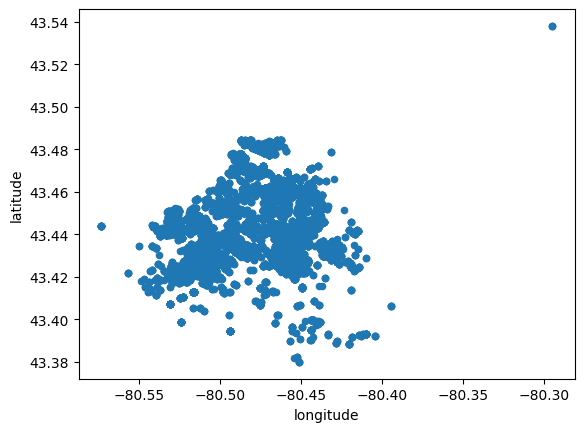

In [41]:
# plot the coordinates
merged_df.plot(x='longitude', y='latitude', kind='scatter')

In [42]:
merged_df.drop(columns=['geometry_x', 'geometry_y'], inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10721 entries, 0 to 10720
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   OBJECTID_x                   10721 non-null  int64  
 1   WATBREAKINCIDENTID           10721 non-null  int64  
 2   INCIDENT_DATE                10721 non-null  int64  
 3   BREAK_TYPE                   10721 non-null  object 
 4   ROAD_CLOSED                  10721 non-null  object 
 5   SIDEWALK_CLOSED              10721 non-null  object 
 6   HOUR_IMPACTED                10721 non-null  object 
 7   UNITS_IMPACTED               1126 non-null   object 
 8   CW_SERVICE_REQUEST           75 non-null     float64
 9   STATUS_x                     10721 non-null  object 
 10  STATUS_DATE                  10097 non-null  float64
 11  WORKORDER                    6092 non-null   float64
 12  RETURN_TO_NORMAL             382 non-null    float64
 13  BREAK_NATURE    